In [1]:
import pandas as pd  # dataset handling
import numpy as np
import geopandas as gpd  # geodataset handling
from keplergl import KeplerGl  # geospatial visualization 

import datetime
import json
import itertools

from prophet import Prophet
from prophet.serialize import model_from_json, model_to_json
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

In [2]:
def create_regressor_column(ds, train_col, test_col, location_id):
    """Get a regressor of train or test data for corresponding timestamp

    Args:
        ds (datetime): timestamp
        train_col (string): column name of regressor in train data
        test_col (string): column name of regressor in test data

    Returns:
        float: regressor value for given timestamp
    """
    
    if ds in df_prophet_reg['ds'].values:
        return df_prophet_reg[df_prophet_reg['ds'] == ds][train_col].values[0]
    elif ds in weather['Frankfurt']['timestamp'].values:
        if location_id <= 124:
            return weather['Frankfurt'][(weather['Frankfurt']['timestamp'] == ds)][test_col].values[0]
        else: 
            return weather['Bremen'][(weather['Bremen']['timestamp'] == ds)][test_col].values[0]
    else:
        return np.nan

In [3]:
def forecast_dict_to_df(forecast: dict) -> pd.DataFrame:
    """Convert forecast dictionary to dataframe

    Args:
        forecast (dict): forecast dictionary from all locations' prophet models

    Returns:
        pd.DataFrame: DataFrame with all forecasts
    """
    forecasts = pd.DataFrame(columns=['ds', 'yhat', 'location_id'])

    for location in list(forecast.keys()):
        forecast[location]['location_id'] = location
        forecasts = pd.concat([forecasts, forecast[location]], axis=0)
    return forecasts

In [4]:
def rmse_per_location(df_rmse: pd.DataFrame, forecast_horizon=168):
    """Calculate RMSE per location

    Args: 
        df_rmse (pd.DataFrame): dataframe with y_true and y_hat values, timestamp and location_id
        forecast_horizon (int): forecast horizon (in hours)
    
    Returns:
        pd.DataFrame: dataframe with RMSE train and test values per location
    """
    locs = df_rmse.location_id.unique().tolist()
    rmse = pd.DataFrame(columns=['RMSE_train', 'RMSE_test', 'PM2p5_mean', 'PM2p5_mean_pred_test', 'PM2p5_mean_pred_train'], index=locs)

    for loc in locs: 
        df_loc = df_rmse[df_rmse.location_id == loc]
        df_loc.dropna(inplace=True)
        rmse.loc[loc, 'RMSE_train'] = mean_squared_error(df_loc['PM2p5'][:-forecast_horizon], df_loc['yhat'][:-forecast_horizon], squared=False)
        rmse.loc[loc, 'RMSE_test'] = mean_squared_error(df_loc['PM2p5'][-forecast_horizon:], df_loc['yhat'][-forecast_horizon:], squared= False)
        rmse.loc[loc, 'PM2p5_mean'] = df_loc['PM2p5'][:-forecast_horizon].mean()

        rmse.loc[loc, 'PM2p5_mean_pred_test'] = (df_loc['yhat'][-forecast_horizon:]).mean()
        rmse.loc[loc, 'PM2p5_mean_pred_train'] = (df_loc['yhat'][:-forecast_horizon]).mean()

    rmse.reset_index(inplace=True)
    rmse.rename(columns={'index': 'location_id'}, inplace=True)
    return rmse


## Importing latest Sensor and Meteomatics data

In [5]:
# load meteomatics data for the cities of interest 
cities = ['Bremen', 'Frankfurt']
# set the day of the downloaded data
day = datetime.datetime(2022, 3, 20).date()
weather = {}

for city in cities: 
    weather[city] = pd.read_csv(f'../data/Meteomatics/auto_processed_weather_forecast_{city}_{day}.csv')
    weather[city].timestamp = pd.to_datetime(weather[city].timestamp)

In [6]:
df = pd.read_csv(f'../data/cleaned_sensors_dwd_2022-03-28.csv', index_col=0)
df.timestamp = pd.to_datetime(df.timestamp) 

In [7]:
df_test_eval = df[(df.timestamp >= weather['Bremen'].timestamp.min()) & (df.timestamp <= weather['Bremen'].timestamp.min() + datetime.timedelta(days=7))][['location_id', 'timestamp', 'PM2p5']]

## Train Prophet on all available data

In [8]:
# set locations
locations = list(df.location_id.unique())

In [9]:
# initialize model
seasonality_mode='additive'
yearly_seasonality=True
weekly_seasonality=True
daily_seasonality=True

growth='logistic' # 'logistic'

# n_changepoints=25
# changepoint_prior_scale = 0.6  #default 0.05

params = {'n_changepoints': [25], # default 25
    #'changepoint_range': [0.8],
    'changepoint_prior_scale': [0.3],  #default 0.05
    #'prior_scale': [0.25, 0.3, 0.35]
    #'seasonality_prior_scale': [10.0]
}

params_grid = [dict(zip(params.keys(), v)) for v in itertools.product(*params.values())]

temp_flag = True
press_flag = True
windsp_flag = True
winddir_flag = True
precip_flag = True

temp_prior_scale = 0.3
press_prior_scale = 0.3
windsp_prior_scale = 0.3
winddir_prior_scale = 0.3
precip_prior_scale = 0.3

if not temp_flag:
    temp_prior_scale = None
if not press_flag:
    press_prior_scale = None
if not windsp_flag:
    windsp_prior_scale = None
if not winddir_flag:
    winddir_prior_scale = None
if not precip_flag:
    precip_prior_scale = None

In [10]:
params_grid

[{'n_changepoints': 25, 'changepoint_prior_scale': 0.3}]

In [11]:
rmse_per_run = {}
runnumber = 0
runs = {}
for para in params_grid:
    runnumber += 1
    models = {}
    limits = pd.DataFrame(index=locations, columns=['cap', 'floor'])
    forecasts = {}
    for location in locations:
        # reduce data to one location
        df_prophet_reg = df.query(f'location_id == {location}')[['location_id', 'timestamp','PM2p5', 'temperature', 'pressure', 'wind_speed', 'wind_direction', 'precip']] 
        df_prophet_reg = df_prophet_reg.sort_values(['timestamp'], axis=0)

        # rename columns to expected format for prophet
        df_prophet_reg.rename(columns={'timestamp': 'ds', 'PM2p5': 'y', 'temperature': 'temp', 'pressure': 'press', 'wind_speed': 'windsp', 'wind_direction': 'winddir', 'precip': 'precip'}, inplace=True)

        # prophet can not handle nans in dataframe
        # df_prophet_reg_all = df_prophet_reg.copy()
        
        # Comment in if using Meteomatics data, for DWD comment out
        df_prophet_reg = df_prophet_reg[df_prophet_reg.ds < weather['Bremen'].timestamp.min()]
        
        df_train = df_prophet_reg[df_prophet_reg.ds < weather['Bremen'].timestamp.min()]
        df_train.dropna(inplace=True, subset=['temp', 'press', 'windsp', 'precip', 'winddir'])
        
        df_average = df_train.query(f'location_id == {location}')[['ds','y']]
        df_average['PM2p5_average'] = (df_average.y.shift(2) + df_average.y.shift(1) + df_average.y + df_average.y.shift(-1) + df_average.y.shift(-2)) / 5

        # add cap column for to set growth = logistic
        cap = df_average.PM2p5_average.quantile(0.99)
        floor = df_average.PM2p5_average.min()

        df_train['cap'] =  cap 
        df_train['floor'] = floor

        df_train.drop('location_id', inplace=True, axis=1)

        model = Prophet(seasonality_mode=seasonality_mode, yearly_seasonality=yearly_seasonality, weekly_seasonality=weekly_seasonality, daily_seasonality=daily_seasonality,
            growth=growth, **para)
        
        # add regressors 
        model.add_regressor('temp', standardize=True, prior_scale=temp_prior_scale)
        model.add_regressor('press', standardize=True, prior_scale=press_prior_scale)
        model.add_regressor('windsp', standardize=True, prior_scale=windsp_prior_scale)
        model.add_regressor('winddir', standardize=True, prior_scale=winddir_prior_scale)
        model.add_regressor('precip', standardize=True, prior_scale=precip_prior_scale)

        # fit model 
        model.fit(df_train)

        models[location] = model

        future = model.make_future_dataframe(periods=168, freq='H')

        # add regressors     
        future['temp'] = future['ds'].apply(create_regressor_column, args=('temp', 'temperature', location))
        future['press'] = future['ds'].apply(create_regressor_column, args=('press', 'pressure', location))
        future['windsp'] = future['ds'].apply(create_regressor_column, args=('windsp', 'wind_speed', location))
        future['winddir'] = future['ds'].apply(create_regressor_column, args=('winddir', 'wind_direction', location))
        future['precip'] = future['ds'].apply(create_regressor_column, args=('precip', 'precip', location))
        future['cap'] = cap
        future['floor'] = floor

        # drop nans
        future.dropna(inplace=True)
        
        # predict
        forecasts[location] = model.predict(future)

    # combine forecasts into one dataframe
    df_forecasts = forecast_dict_to_df(forecasts)
    df_eval = df[(df.timestamp >= df_forecasts.ds.min()) & (df.timestamp <= df_forecasts.ds.max())][['location_id', 'timestamp', 'PM2p5']]
    df_eval.rename(columns={'timestamp': 'ds'}, inplace=True)
    df_rmse = df_forecasts[['location_id','ds', 'yhat']].merge(df_eval, on=['location_id', 'ds'], how='left')

    runs[runnumber] = list(para.values())
    rmse_per_run[runnumber] = rmse_per_location(df_rmse)

    # save model and forecasts
    for location_id in locations:
        model_json = model_to_json(models[location_id])
        with open(f'../models/final_model_meteo_{location_id}.json', 'w') as f:
            json.dump(model_json, f)
        forecasts[location_id].to_csv(f'../models/final_forecast_meteo_{location_id}.csv')

        

Initial log joint probability = -201.12
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       47613.6    0.00468748       2720.27           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       48180.5    0.00284114       1175.79           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       48407.6     0.0343565       2265.57           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       48450.7    0.00158744       721.924           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       48472.2    0.00244066       1435.99      0.6818      0.6818      552   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [12]:
#rmse_per_run[0] = rmse_per_location(df_rmse)

## Analysis of results and plots for the presentation

In [13]:
# import libraries for plotting 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [14]:
# put RMSE per run into DataFrame and add city 

for frame in list(rmse_per_run.values()):
    df_rmse_per_run = frame

df_rmse_per_run = pd.merge(left=df_rmse_per_run, right=df.groupby(['location_id']).city.first().reset_index(), on='location_id', how='left')

df_rmse_per_run.sort_values('location_id')

,location_id,RMSE_train,RMSE_test,PM2p5_mean,PM2p5_mean_pred_test,PM2p5_mean_pred_train,city
0,2,4.944798,5.879383,6.174036,14.585931,6.295716,Frankfurt
53,8,2.326356,2.112777,2.593666,5.817733,2.645909,Frankfurt
1,10,3.863883,5.493621,5.421608,7.767,5.430613,Frankfurt
2,11,5.32239,8.140835,6.276161,10.882008,6.288478,Frankfurt
3,12,4.590604,3.543846,4.905865,7.559002,4.938894,Frankfurt
...,...,...,...,...,...,...,...
46,169,5.447671,12.796465,7.088996,9.376112,7.092599,Bremen
42,170,8.760923,13.480072,10.412734,14.159417,10.424428,Bremen
61,179,5.73197,9.731588,7.3771,10.401585,7.378747,Bremen
43,180,1.380608,3.634267,1.450538,1.604102,1.455157,Bremen


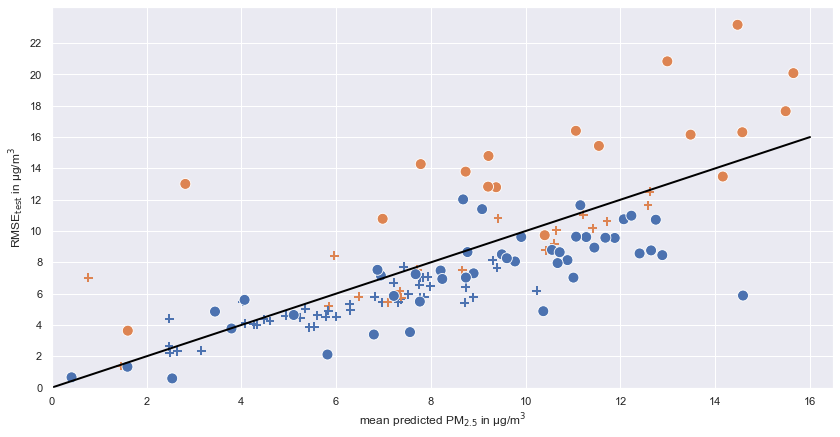

In [15]:
# plot RMSE_test vs. PM_predicted_test
sns.set_context("talk")
cmap = ['#4c72b0', '#dd8552'] # blue and orange 
sns.set_theme()

plt.figure(figsize=(14,7))
p = sns.scatterplot(data = df_rmse_per_run, x='PM2p5_mean_pred_train', y='RMSE_train', color='#4c72b0', s=80, hue='city', style=1, markers="+", linewidth=2) #style='city', markers={"Bremen": "s", "Frankfurt": "o"})
p = sns.scatterplot(data = df_rmse_per_run, x='PM2p5_mean_pred_test', y='RMSE_test', color='green', s=120, hue='city', style=1, markers="o")
plt.yticks(np.arange(0, 24, step=2))
plt.xlim(0)
plt.ylim(0)
plt.xlabel('mean predicted PM$_{2.5}$ in µg/m$^3$')
plt.ylabel('RMSE$_{\mathrm{test}}$ in µg/m$^3$')
plt.legend().remove() # no legend shown
plt.plot([0, 16], [0, 16], linewidth=2, color='black');

plt.savefig(f'../figures/RMSE_PM2p5_mean.png', transparent=True, bbox_inches='tight', dpi=400)

In [16]:
#  calc mean PM2p5 value per location and predicted day
df_test_eval['date'] = df_test_eval.timestamp.dt.date
pm_mean = df_test_eval.groupby(['location_id', 'date']).mean().reset_index()
# add column for number of predicted day to DataFrame
pm_mean['day'] = pd.to_datetime(pm_mean['date']).dt.day - 19
pm_mean

,location_id,date,PM2p5,day
0,2,2022-03-20,16.373847,1
1,2,2022-03-21,13.719062,2
2,2,2022-03-22,10.934848,3
3,2,2022-03-23,13.357457,4
4,2,2022-03-24,19.916107,5
...,...,...,...,...
507,182,2022-03-23,15.303893,4
508,182,2022-03-24,23.588023,5
509,182,2022-03-25,28.814381,6
510,182,2022-03-26,25.192079,7


In [17]:
# create DataFrame with predicted (yhat) and measured PM2p5 values for each location and time
df_rmse_test = df_test_eval.merge(df_forecasts[['ds', 'yhat', 'location_id']], left_on=['timestamp', 'location_id'], right_on=['ds', 'location_id'], how='inner')
df_rmse_test['date'] = df_rmse_test.ds.dt.date
df_rmse_test.dropna(inplace=True)
df_rmse_test


,location_id,timestamp,PM2p5,date,ds,yhat
0,2,2022-03-20 08:00:00,24.767500,2022-03-20,2022-03-20 08:00:00,14.794223
1,2,2022-03-20 09:00:00,24.295833,2022-03-20,2022-03-20 09:00:00,14.666601
2,2,2022-03-20 10:00:00,23.949524,2022-03-20,2022-03-20 10:00:00,14.364502
3,2,2022-03-20 11:00:00,24.832105,2022-03-20,2022-03-20 11:00:00,13.673842
4,2,2022-03-20 12:00:00,19.177333,2022-03-20,2022-03-20 12:00:00,12.887301
...,...,...,...,...,...,...
10747,94,2022-03-27 03:00:00,17.705000,2022-03-27,2022-03-27 03:00:00,8.222313
10748,94,2022-03-27 04:00:00,16.678333,2022-03-27,2022-03-27 04:00:00,8.624710
10749,94,2022-03-27 05:00:00,18.711667,2022-03-27,2022-03-27 05:00:00,9.034543
10750,94,2022-03-27 06:00:00,18.238333,2022-03-27,2022-03-27 06:00:00,9.284468


In [18]:
# calculate mean RMSE per location and day(date)/day_index(forecasted day)
# create DataFrame for results
pm_rmse = pd.DataFrame(columns=['location_id', 'day_index', 'rmse', 'day'], index=np.arange(0,len(locations)*7))
i = 0
for location in locations:
    df_location = df_rmse_test.query(f"location_id == {location}")
    day_index = 1
    for day in sorted(list(set(list(df_location.date.values)))):
        df_location_day = df_location[df_location['date'] == day]
        pm_rmse.loc[i, 'rmse'] = mean_squared_error(df_location_day['PM2p5'], df_location_day['yhat'], squared=False)
        pm_rmse.loc[i,'day_index'] = day_index
        pm_rmse.loc[i,'location_id'] = location
        pm_rmse.loc[i,'day'] = day
        i += 1
        day_index += 1

pm_rmse.sort_values(['location_id', 'day'])       

,location_id,day_index,rmse,day
0,2,1,5.735058,2022-03-20
1,2,2,1.285915,2022-03-21
2,2,3,3.619755,2022-03-22
3,2,4,3.100316,2022-03-23
4,2,5,6.206309,2022-03-24
...,...,...,...,...
353,182,4,5.952333,2022-03-23
354,182,5,13.719963,2022-03-24
355,182,6,22.444244,2022-03-25
356,182,7,26.391978,2022-03-26


In [19]:
# add city to DataFrame
pm_rmse['city'] = ['Frankfurt' if x < 125 else 'Bremen' for x in pm_rmse['location_id']]
pm_mean['city'] = ['Frankfurt' if x < 125 else 'Bremen' for x in pm_mean['location_id']]

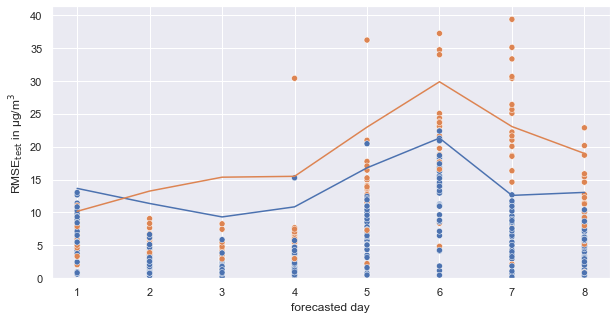

In [20]:
# plot RMSE_test vs. forcasted day (day_index)
sns.set_context("talk")
cmap = ['#4c72b0', '#dd8552'] # blue and orange 
sns.set_theme()

plt.figure(figsize=(10,5))
sns.scatterplot(data=pm_rmse, x='day_index', y='rmse', hue='city')
sns.lineplot(data=pm_mean, x='day', y='PM2p5', hue='city', ci=None)
plt.ylim(0)
plt.xlabel('forecasted day')
plt.ylabel('RMSE$_{\mathrm{test}}$ in µg/m$^3$')
plt.legend().remove() # no legend shown

plt.savefig(f'../figures/RMSE_test_per_day.png', transparent=True, bbox_inches='tight', dpi=300)

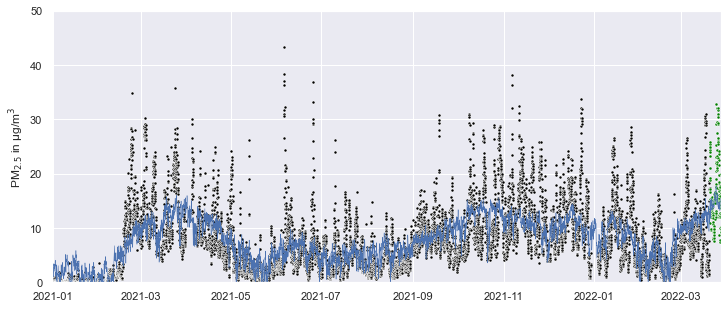

In [21]:
# plot long result
location =  2 # 27 84 location to be used for plot
timestamp = '2022-03-20 00:08:00' # where to start with green (test) dots

sns.set_context("talk")
cmap = ['#4c72b0', '#dd8552'] # blue and orange 
sns.set_theme()

plt.figure(figsize=(12,5))
sns.scatterplot(data=df.query(f'location_id == {location}'), x='timestamp', y='PM2p5', color='black', marker='.')
sns.scatterplot(data=df.query(f"location_id == {location} and timestamp >= '{timestamp}'"), x='timestamp', y='PM2p5', color='green', marker='.')
sns.lineplot(forecasts[location].ds, forecasts[location].yhat, color='#4c72b0', linewidth=0.5)
plt.ylim(0, 50)
plt.xlim(pd.to_datetime('2020-12-31'), pd.to_datetime('2022-03-28'));
plt.xlabel('')
plt.ylabel('PM$_{2.5}$ in µg/m$^3$')

plt.savefig(f'../figures/PM2p5_prediction_location{location}.png', transparent=True, bbox_inches='tight', dpi=500)

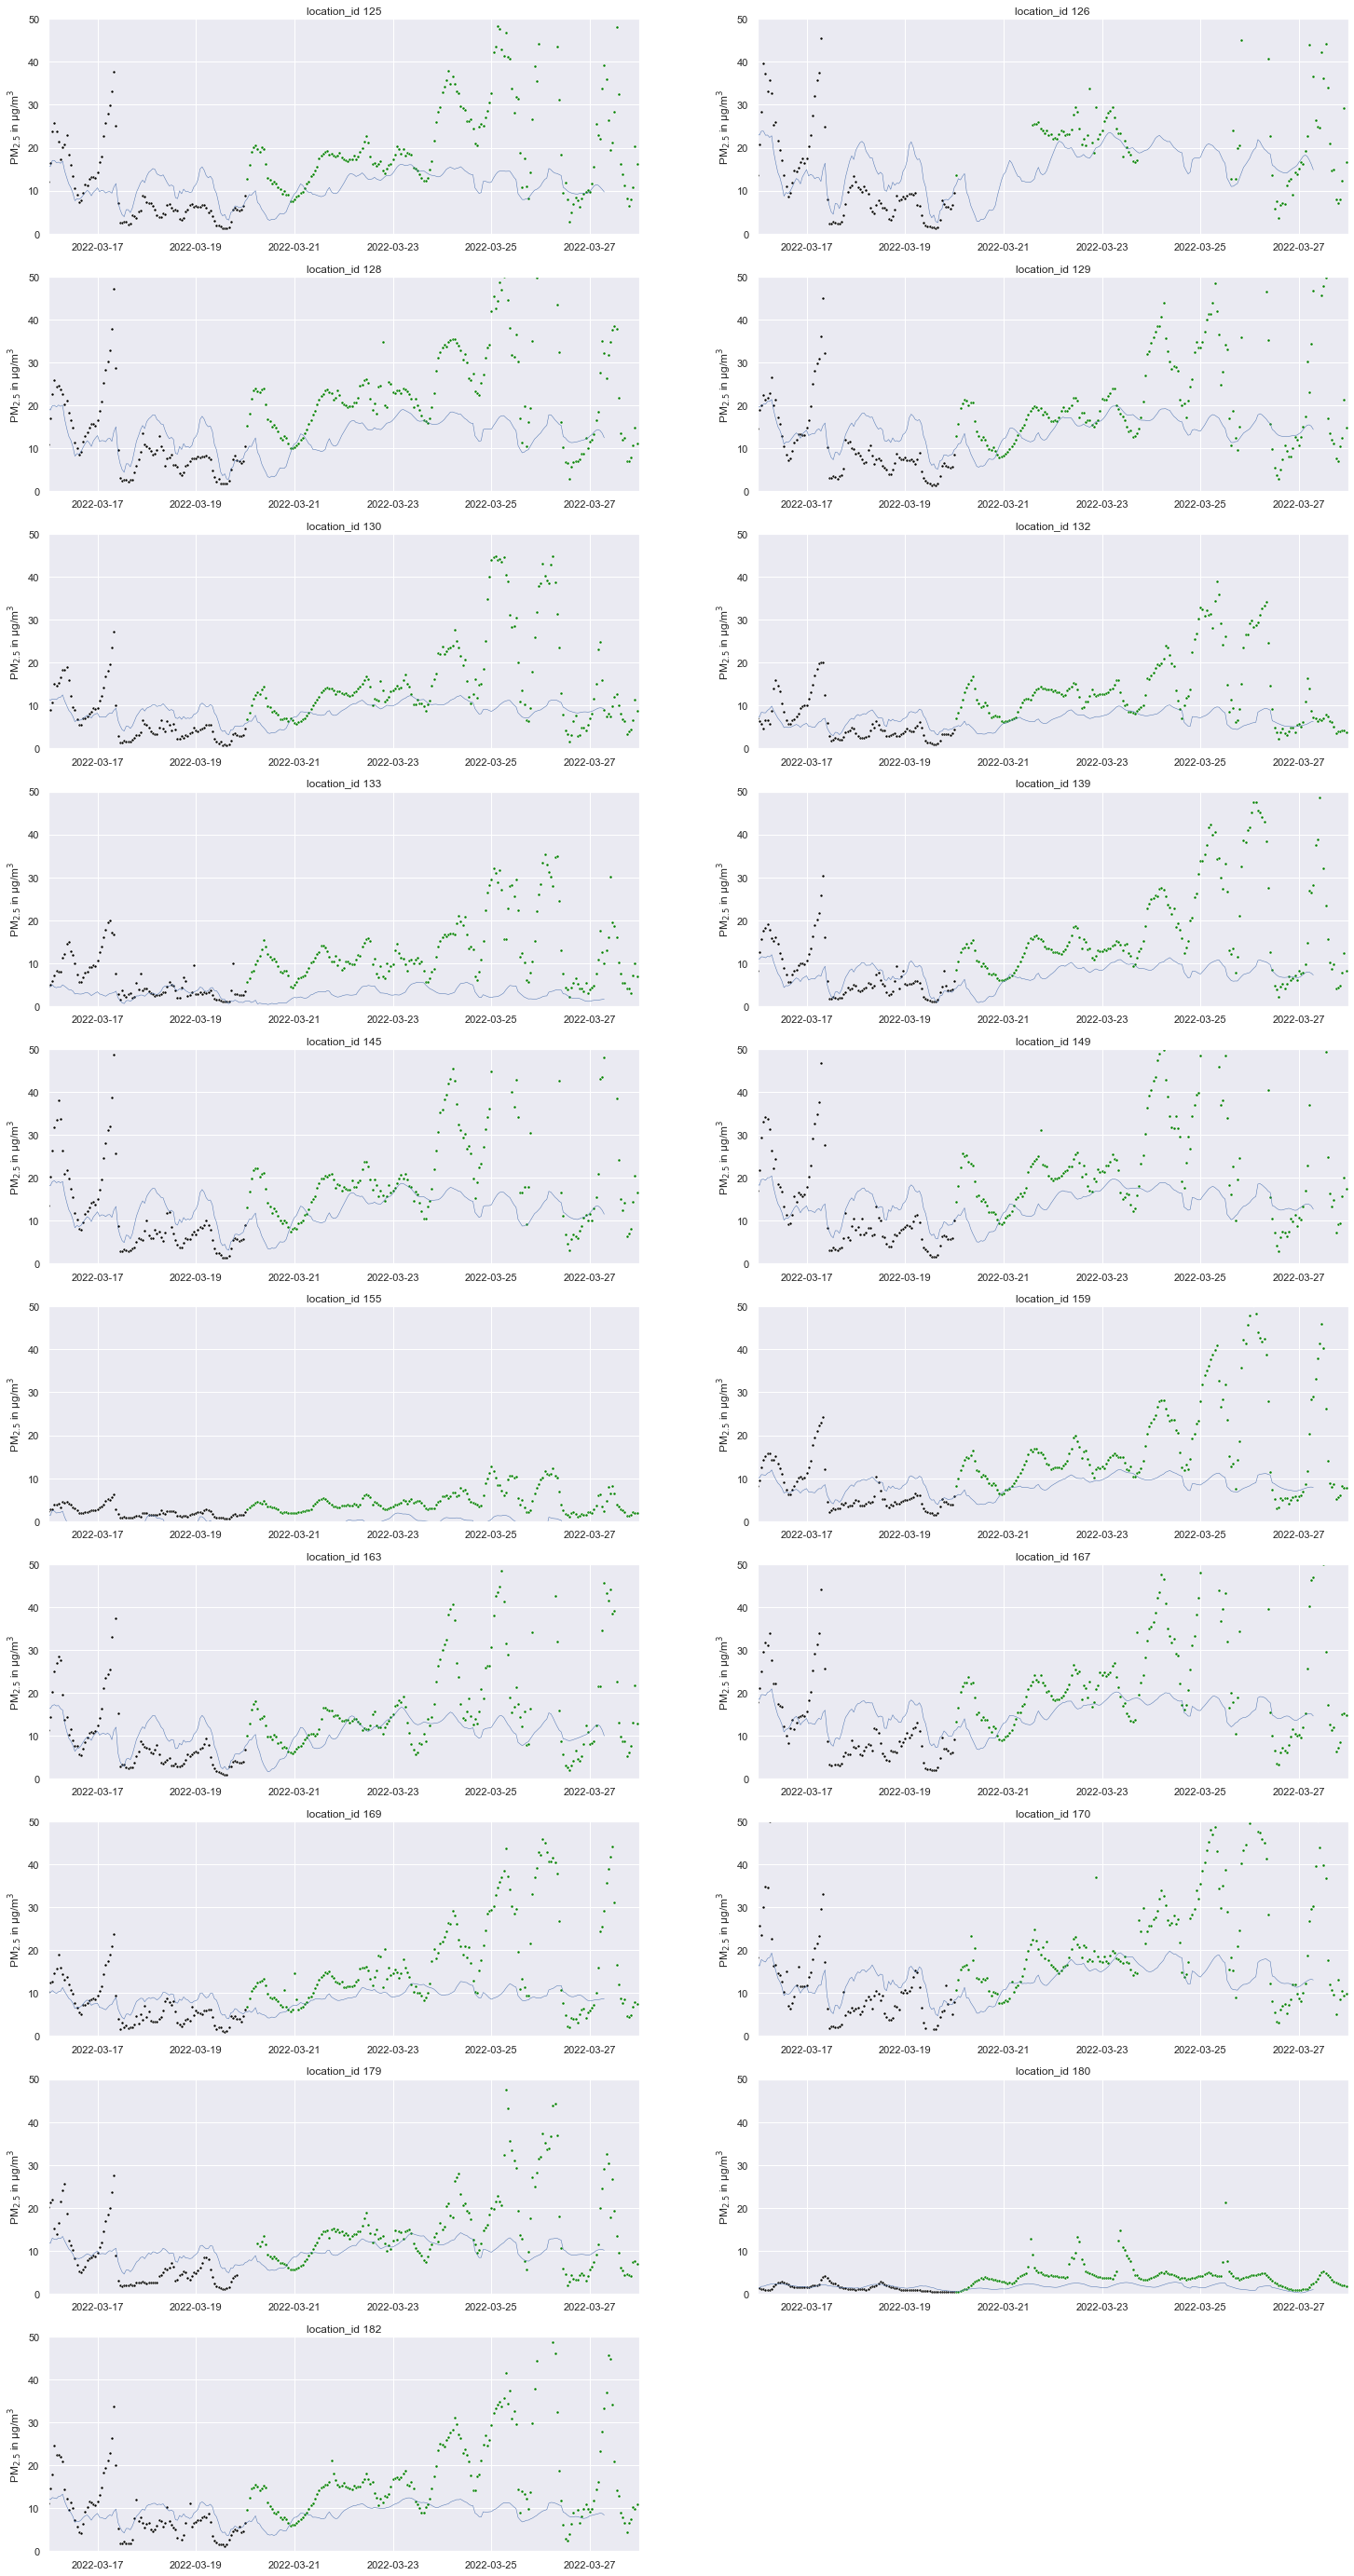

In [22]:
# plot fit for all locations in Bremen
locations_bremen = [125, 126, 128, 129, 130, 132, 133, 139, 145, 149, 155, 159, 163, 167, 169, 170, 179, 180, 182]
plt.figure(figsize=(25,50))

for i, location in enumerate(locations_bremen):
    plt.subplot(10,2,i+1)
    
    sns.scatterplot(data=df.query(f'location_id == {location}'), x='timestamp', y='PM2p5', color='black', marker='.')
    sns.scatterplot(data=df.query(f"location_id == {location} and timestamp >= '{timestamp}'"), x='timestamp', y='PM2p5', color='green', marker='.')
    sns.lineplot(forecasts[location].ds, forecasts[location].yhat, color='#4c72b0', linewidth=0.5)
    plt.ylim(0, 50)
    plt.xlim(pd.to_datetime('2022-03-16'), pd.to_datetime('2022-03-28'));
    plt.xlabel('')
    plt.ylabel('PM$_{2.5}$ in µg/m$^3$')
    plt.title(f'location_id {location}')    

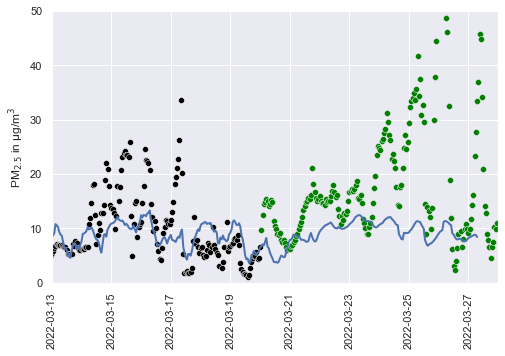

In [23]:
# plot selection
plt.figure(figsize=(8,5))
sns.scatterplot(data=df.query(f'location_id == {location}'), x='timestamp', y='PM2p5', color='black', marker='o')
sns.scatterplot(data=df.query(f"location_id == {location} and timestamp >= '{timestamp}'"), x='timestamp', y='PM2p5', color='green', marker='o')
sns.lineplot(forecasts[location].ds, forecasts[location].yhat, color='#4c72b0', linewidth=2)
plt.ylim(0, 50)
plt.xlim(pd.to_datetime('2022-03-13'), pd.to_datetime('2022-03-28'))
plt.xlabel('')
plt.ylabel('PM$_{2.5}$ in µg/m$^3$')
plt.xticks(rotation=90);

plt.savefig(f'../figures/PM2p5_prediction_location{location}_last_2_weeks.png', transparent=True, bbox_inches='tight', dpi=400)

# Fill future dataframe with meteomatics data

## Visualization with Kepler.gl

In [24]:
# get GPS data and merge with forecast dataframe since kepler.gl needs GPS data
df_gps = df[['location_id', 'lat', 'lon']].groupby(['location_id']).first().reset_index()

In [25]:
df_kepler = df_forecasts.merge(df_gps, how='left', on='location_id')[['ds', 'yhat', 'location_id', 'lat', 'lon']]

In [26]:
df_kepler.dropna(subset=['yhat'], inplace=True)

In [27]:
# make dummies
timestamps = pd.Series(df_kepler['ds'].unique(), name='ds')

dummies = pd.DataFrame(data={
    'location_id': -1,
    'lat': [0, 90],
    'lon': [0, 90],
    'yhat': [0, 50]
})

dummies = dummies.merge(timestamps, how='cross')

df_kepler = pd.concat([df_kepler, dummies])

In [28]:
# Adjust plotting time horizon
df_kepler = df_kepler.sort_values('ds').query('ds > "2022-03"')

In [29]:
# Create bins for PM2p5 for Hexbin plotting
pm2p5_bins = np.append(0,np.arange(0, 50, 5))
pm2p5_labels = pm2p5_bins
pm2p5_labels[0] = -1
pm2p5_bins = np.append(pm2p5_bins, 1000)
pm2p5_bins[0] = -20

In [30]:
print(pm2p5_bins)

[ -20    0    5   10   15   20   25   30   35   40   45 1000]


In [31]:
df_kepler['PM2p5_bins'] = pd.cut(df_kepler['yhat'], bins=pm2p5_bins, labels=pm2p5_labels).astype(int)

In [32]:
# Make the geo DataFrame
gdf_sensors = gpd.GeoDataFrame(
    df_kepler, 
    geometry=gpd.points_from_xy(
        x=df_kepler['lon'],
        y=df_kepler['lat']
    )
)

In [33]:
# Creating a Datetime column (Kepler is funny about datetimes)
gdf_sensors['timestamp'] = pd.to_datetime(gdf_sensors['ds'])
gdf_sensors['timestamp'] = gdf_sensors['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Selecting only columns we need
gdf_sensors = gdf_sensors[[
    'yhat', 'lon', 'lat', 'geometry', 'timestamp',  'PM2p5_bins', 'location_id'
]]

gdf_sensors

,yhat,lon,lat,geometry,timestamp,PM2p5_bins,location_id
192539,0.412360,8.640,50.108,POINT (8.64000 50.10800),2022-03-01 01:00:00,0,37
173222,10.387207,8.702,50.106,POINT (8.70200 50.10600),2022-03-01 01:00:00,10,35
540245,7.143537,8.568,50.168,POINT (8.56800 50.16800),2022-03-01 01:00:00,5,111
501611,1.810678,8.642,50.158,POINT (8.64200 50.15800),2022-03-01 01:00:00,0,103
462977,8.920924,8.680,50.150,POINT (8.68000 50.15000),2022-03-01 01:00:00,5,98
...,...,...,...,...,...,...,...
193169,0.317145,8.640,50.108,POINT (8.64000 50.10800),2022-03-27 07:00:00,0,37
212486,12.343562,8.704,50.112,POINT (8.70400 50.11200),2022-03-27 07:00:00,10,41
989182,12.804199,8.662,50.114,POINT (8.66200 50.11400),2022-03-27 07:00:00,10,44
347705,2.095491,8.698,50.126,POINT (8.69800 50.12600),2022-03-27 07:00:00,0,71


In [34]:
gdf_sensors[gdf_sensors.yhat < 0].location_id.unique()

array([71, 155, 120, 126, 133], dtype=object)

In [35]:
%run config.py
map_config = config

<Figure size 432x288 with 0 Axes>

In [36]:
kepler_map = KeplerGl(
    height=800,
    data={
        'Sensors': gdf_sensors,
    }, config=map_config
)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [37]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Sensors'], 'id': 'c717e9s',…

### Export for Kepler.gl or Unfolded online use

In [38]:
df_kepler.to_csv('../data/kepler.csv', index=False)